In [1]:
%load_ext autoreload
%autoreload 2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import preproc as pp


class COVID(object):
    def __init__(self):
        self.DATA_PATH = "../coronavirusdataset/"
        self.patient_route = pp.patient_route(self.DATA_PATH)
        self.case, self.group_map = pp.case(self.DATA_PATH)
        self.patient_info = pp.patient_info(self.DATA_PATH)
        self.patient_num = self.patient_info.shape[0]
        self.pre_proc()

    def pre_proc(self):
        # >>> patient_info:
        # fill missing value: infection_case, use etc
        self.patient_info["infection_case"].fillna("etc", inplace=True)
        # fill missing value: contact_number, use 0
        self.patient_info["contact_number"].fillna(0, inplace=True)
        # fill missing value: infected_by, use -1
        self.patient_info["infected_by"].fillna(-1, inplace=True)
        # fill missing value: sex, use ratio of all, generate a shuffle list then fill in the blank
        sex_count = dict(self.patient_info["sex"].value_counts())
        sex_num = sex_count["female"] + sex_count["male"]
        un_sex_male = int((self.patient_num - sex_num) * sex_count["male"] / sex_num)
        un_sex_female = int((self.patient_num - sex_num) - un_sex_male)
        fill_sex_list = ["male" for _ in range(0, un_sex_male)] + ["female" for _ in range(0, un_sex_female)]
        random.shuffle(fill_sex_list)
        self.patient_info.loc[self.patient_info["sex"].isnull(), "sex"] = fill_sex_list
        # fill missing value: age, use mean of province
        # # 1. fill bo
        all_age = self.patient_info.birth_year.mean()
        province_age = self.patient_info.groupby('province').birth_year.mean()
        province_age.loc[province_age.isnull()] = all_age
        fill_birth_list_idx = self.patient_info.loc[self.patient_info["birth_year"].isnull(), "birth_year"].index
        fill_birth_list = list(province_age[self.patient_info.loc[fill_birth_list_idx, "province"]])
        self.patient_info.loc[self.patient_info["birth_year"].isnull(), "birth_year"] = fill_birth_list
        # # 2. fill age
        fill_age_list_idx = self.patient_info.loc[self.patient_info["age"].isnull(), "age"].index
        cal_year_list = np.array(list(self.patient_info.loc[fill_age_list_idx, "birth_year"]))
        cal_year_list = (2020 - cal_year_list) / 10
        cal_year_list = cal_year_list.astype(int) * 10
        cal_year_list = [str(cal_year_list[i]) + 's' for i in range(cal_year_list.shape[0])]
        self.patient_info.loc[self.patient_info["age"].isnull(), "age"] = cal_year_list
        # drop country
        self.patient_info.drop(columns=["country"], inplace=True)
        # fill missing value: city
        self.patient_info.loc[self.patient_info["city"] == "etc", "city"] = None
        self.patient_route["most_city"] = self.patient_route.groupby('patient_id').city.transform(
            lambda x: x.value_counts().index[0])
        fill_city_list_idx = self.patient_info.loc[self.patient_info["city"].isnull(), "city"].index
        route_most_city = self.patient_route.groupby('patient_id').most_city.max()
        fill_city_list_pid = self.patient_info.loc[fill_city_list_idx, "patient_id"]
        for idx, pid in fill_city_list_pid.iteritems():
            if pid in route_most_city.index:
                self.patient_info.loc[idx, "city"] = route_most_city[pid]
        self.patient_info["tmp"] = self.patient_info.groupby('province').city.transform(
            lambda x: x.value_counts().index[0])
        fill_city_list_idx = self.patient_info.loc[self.patient_info["city"].isnull(), "city"].index
        prov_most_city = self.patient_info.groupby('province').tmp.max()
        fill_city_list_pid = self.patient_info.loc[fill_city_list_idx, "patient_id"]
        for idx, pid in fill_city_list_pid.iteritems():
            # print(self.patient_info.loc[idx, "province"])
            self.patient_info.loc[idx, "city"] = prov_most_city[self.patient_info.loc[idx, "province"]]
        # date formatting
        self.patient_info.loc[776, "symptom_onset_date"] = None
        self.patient_info["confirmed_date"] = pd.to_datetime(self.patient_info.confirmed_date)
        self.patient_info["symptom_onset_date"] = pd.to_datetime(self.patient_info.symptom_onset_date)
        self.patient_info["released_date"] = pd.to_datetime(self.patient_info.released_date)
        self.patient_info["deceased_date"] = pd.to_datetime(self.patient_info.deceased_date)

        # >>> patient_route:
        self.patient_route["date"] = pd.to_datetime(self.patient_route.date)
        self.patient_info["start_date"] = pd.NaT
        for i, row in self.patient_info.iterrows():
            pid = row["patient_id"]
            dating = self.patient_route[self.patient_route["patient_id"] == pid]
            self.patient_info.loc[self.patient_info["patient_id"] == pid, "group"] = self.group_map[row["infection_case"]]
            if row["symptom_onset_date"] is not pd.NaT:
                if dating.shape[0] == 0:
                    self.patient_info.loc[i, "start_date"] = row["symptom_onset_date"]
                    continue
                dating_b = dating[dating["date"] <= row["symptom_onset_date"]]
                if dating_b.shape[0] == 0:
                    self.patient_info.loc[i, "start_date"] = row["symptom_onset_date"]
                    continue
                self.patient_info.loc[i, "start_date"] = dating_b.tail(1).reset_index().at[0, "date"]
            else:
                if dating.shape[0] == 0:
                    self.patient_info.loc[i, "start_date"] = row["confirmed_date"]
                    continue
                dating_b = dating[dating["date"] <= row["confirmed_date"]]
                if dating_b.shape[0] == 0:
                    self.patient_info.loc[i, "start_date"] = row["confirmed_date"]
                    continue
                self.patient_info.loc[i, "start_date"] = dating_b.tail(1).reset_index().at[0, "date"]
        print(self.patient_info.isnull().sum())
        # fill missing value: sym date
        # self.patient_info.to_excel("./tmp/patient_info.xlsx")


    def draw(self):
        patient_info = self.patient_info.copy()
        # sex
        sex = patient_info["sex"]

In [2]:
covid_model = COVID()

patient_id               0
sex                      0
birth_year               0
age                      0
province                 0
city                     0
infection_case           0
infected_by              0
contact_number           0
symptom_onset_date    2683
confirmed_date           0
released_date         2147
deceased_date         3072
state                    0
group                    0
tmp                      0
start_date               0
dtype: int64


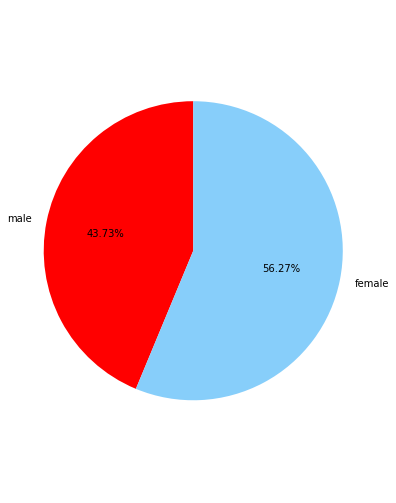

In [3]:
# plot: sex
sex_stat = covid_model.patient_info["sex"].value_counts()
plt.rcParams['font.family'] = ['DejaVu Sans']
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.figure(figsize=(6,9)) #调节图形大小
labels = [u'male',u'female'] #定义标签
sizes = [sex_stat["male"],sex_stat["female"]] #每块值
colors = ['red','lightskyblue'] #每块颜色定义
explode = (0,0) #将某一块分割出来，值越大分割出的间隙越大
patches,text1,text2 = plt.pie(sizes,
                      explode=explode,
                      labels=labels,
                      colors=colors,
                      autopct = '%3.2f%%', #数值保留固定小数位
                      shadow = False, #无阴影设置
                      startangle =90, #逆时针起始角度设置
                      pctdistance = 0.6) #数值距圆心半径倍数距离
#patches饼图的返回值，texts1饼图外label的文本，texts2饼图内部的文本
# x，y轴刻度设置一致，保证饼图为圆形
plt.axis('equal')
plt.show()

In [ ]:
import folium
import pandas as pd
from folium import plugins

# define the kr map
loc = [36.4268093, 126.5512681]
kr_map = folium.Map(location=loc, zoom_start=7)

# add all patient
incidents = plugins.MarkerCluster().add_to(kr_map)
for lat, lng, label, in zip(covid_model.patient_route.latitude, covid_model.patient_route.longitude, covid_model.patient_route.province):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(incidents)

# display kr map
kr_map

In [ ]:
heatdata = covid_model.patient_route[['latitude','longitude']].values.tolist()
plugins.HeatMap(heatdata).add_to(kr_map)
kr_map